In [36]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from glob import glob
from datetime import timedelta,datetime
from tqdm import tqdm
import numba
import numpy as np
import time,functools
pd.set_option('display.max_rows', 300*2)

In [53]:
file_list = glob(r"E:\work_dir\workFile\stockProject\history_data\*.pkl")
file_path = sorted(file_list)[-1]
df = pd.read_pickle(file_path)
df['date'] = df.date.astype('datetime64')
df.sort_values(['symbol','date'],inplace=True,ignore_index=True)
date_map = dict(zip(df.index,df.date))
df['turnover'] = df.volume * df.close * 100

In [54]:
show_column = ['stock_name','symbol','start_date','end_date','gains','_type','buy_date','sell_date','buy_price','sell_price','sell_date','G6','G5','G3','G1','G0','close']

In [55]:
cc = pd.read_pickle(r"E:/work_dir/workFile/stockProject/results/god.pkl")

#### 平均利润

In [5]:
cc.query('gains_sign == gains_sign').groupby('_type').gains.mean()

_type
G0    0.168379
G1    0.109399
G3    0.066566
G5    0.054139
G6    0.043515
Name: gains, dtype: float64

#### 平均胜率

In [6]:
(cc.loc[(cc.gains.notna())
         #&(cc.is_shadow)
        ]
        .groupby(['_type','gains_sign'])['stock_name'].
        count().
        unstack().rename(columns={False:'loss',True:'win'}).
        assign(_sum=lambda x:x.win + x.loss).
        assign(ratio=lambda x:x.win/x._sum)
        )

gains_sign,loss,win,_sum,ratio
_type,,,,
G0,8,239,247,0.967611
G1,44,745,789,0.944233
G3,132,1384,1516,0.912929
G5,246,1721,1967,0.874936
G6,369,1463,1832,0.798581


#### 利润分布图

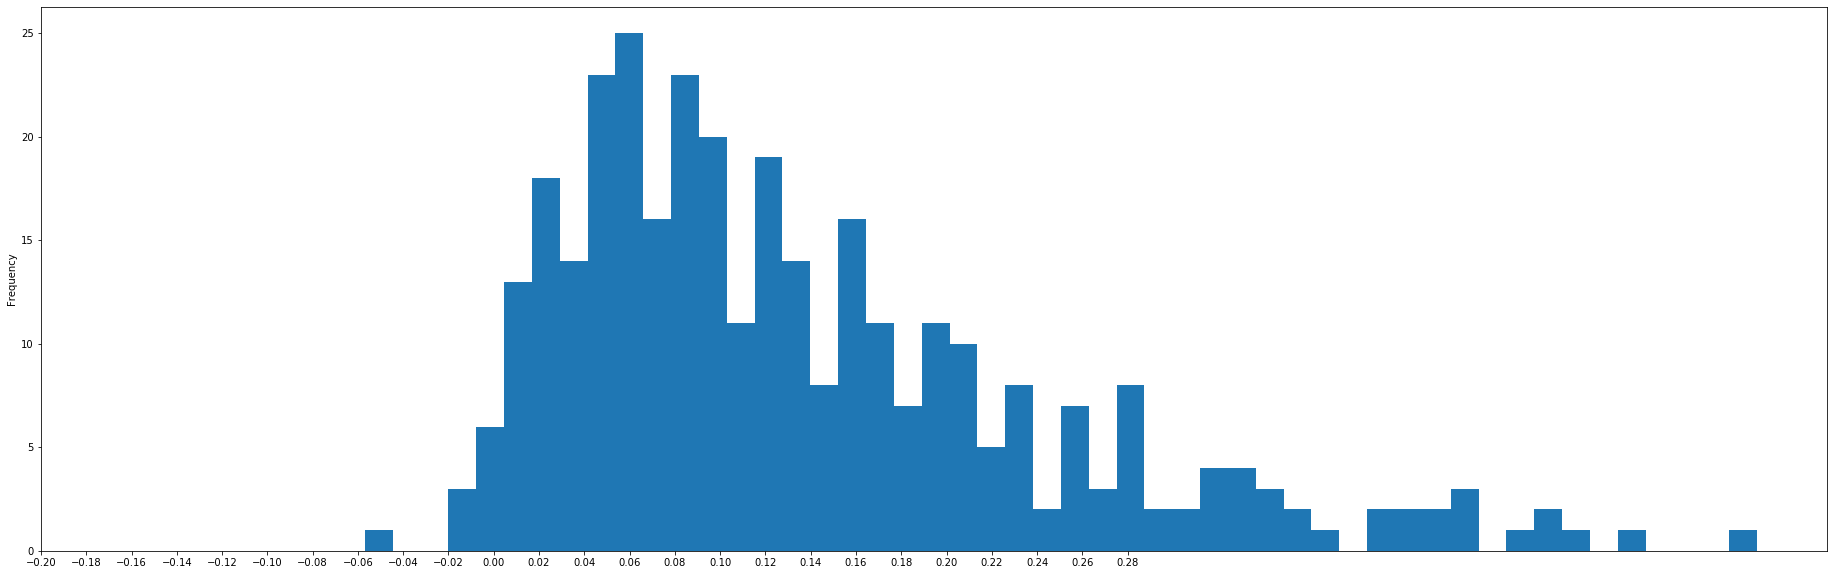

In [16]:
x = -0.2
s = []
while x < 0.3:
    s.append(x)
    x+= 0.02
cc.loc[cc.gains==cc.gains].query("_type == 'G1'")['gains'].plot(figsize=(32,10),kind="hist",xticks=s,bins=50)

#### 各个赢利点胜率

In [34]:
cc = pd.read_pickle(r"E:/work_dir/workFile/stockProject/results/god.pkl")

In [50]:
cc.query("gains==gains and _type=='G0'").groupby(pd.Grouper(key='buy_date',freq='1M')).stock_name.count().median()

2.0

In [48]:
df2 = cc.loc[(cc.gains.notna())
             &(cc.is_shadow==True)  
            ].filter(regex='^point_\d+|_type').set_index(['_type']).stack().reset_index()
df2.columns = ['_type','point','win']
point = pd.CategoricalDtype(categories={f"point_{i}":round(1 + i/100,2) for i in range(1,23)}.keys(),ordered=True)
_type = pd.CategoricalDtype(categories=['G6','G5','G3','G1','G0'],ordered=True)
ratio = (
    df2.groupby(['_type','point','win'])['_type']
    .count().
    unstack().
    assign(_sum=lambda x:x.sum(axis=1)).
    assign(ratio=lambda x:x[True]/x['_sum']).
    reset_index().
    astype({'point':point,'_type':_type}).sort_values(['_type','point'])
)
ratio.pivot(index='_type',values=['ratio'],columns=['point'])

ratio                                                              \
point   point_1   point_2   point_3   point_4   point_5   point_6   point_7   
_type                                                                         
G6     0.877984  0.840849  0.777188  0.687003  0.588859  0.496021  0.432361   
G5     0.914216  0.850490  0.806373  0.698529  0.622549  0.551471  0.473039   
G3     0.933735  0.891566  0.834337  0.765060  0.683735  0.590361  0.500000   
G1     0.992063  0.960317  0.936508  0.912698  0.880952  0.801587  0.761905   
G0     1.000000  1.000000  1.000000  0.918919  0.891892  0.891892  0.891892   

                                     ...                                \
point   point_8   point_9  point_10  ...  point_13  point_14  point_15   
_type                                ...                                 
G6     0.400531  0.347480  0.278515  ...  0.132626  0.095491  0.079576   
G5     0.397059  0.343137  0.303922  ...  0.181373  0.149510  0.134804   
G3     0.406627  0.310241  0.280120  ...  0.186747  0.153614  0.126506   
G1     0.706349  0.690476  0.642857  ...  0.500000  0.460317  0.444444   
G0     0.837838  0.837838  0.756757  ...  0.702703  0.648649  0.621622   

                                                                             
point  point_16  point_17  point_18  point_19  point_20  point_21  point_22  
_type                                                                        
G6     0.066313  0.061008  0.053050  0.047745  0.039788  0.031830  0.018568  
G5     0.115196  0.100490  0.090686  0.063725  0.058824  0.051471  0.049020  
G3     0.102410  0.093373  0.081325  0.069277  0.057229  0.045181  0.045181  
G1     0.420635  0.357143  0.317460  0.293651  0.253968  0.206349  0.190476  
G0     0.567568  0.567568  0.513514  0.459459  0.432432  0.432432  0.405405  

[5 rows x 22 columns]

In [79]:
df2 = cc.query('gains==gains').filter(regex='^loss_point_\d+|_type').set_index(['_type']).stack().reset_index()
df2.columns = ['_type','point','win']
point = pd.CategoricalDtype(categories={f"loss_point_{i}": 2 - round(1 + i/100,2) for i in range(1,23)}.keys(),ordered=True)
_type = pd.CategoricalDtype(categories=['G6','G5','G3','G1','G0'],ordered=True)
ratio = (
    df2.groupby(['_type','point','win'])['_type']
    .count().
    unstack().
    assign(_sum=lambda x:x.sum(axis=1)).
    assign(ratio=lambda x:x[True]/x['_sum']).
    reset_index().
    astype({'point':point,'_type':_type}).sort_values(['_type','point'])
)
ratio.pivot(index='_type',values=['ratio'],columns=['point'])

ratio                                                      \
point loss_point_1 loss_point_2 loss_point_3 loss_point_4 loss_point_5   
_type                                                                    
G6        0.324449     0.269301     0.216912     0.177390     0.137868   
G5        0.322993     0.260036     0.208942     0.154197     0.124088   
G3        0.331081     0.255631     0.190315     0.132883     0.103604   
G1        0.489914     0.389049     0.340058     0.293948     0.256484   
G0        0.631148     0.590164     0.557377     0.508197     0.475410   

                                                                         ...  \
point loss_point_6 loss_point_7 loss_point_8 loss_point_9 loss_point_10  ...   
_type                                                                    ...   
G6        0.112132     0.086397     0.060662     0.047794      0.037684  ...   
G5        0.091241     0.070255     0.042883     0.031934      0.027372  ...   
G3        0.074324     0.056306     0.034910     0.023649      0.019144  ...   
G1        0.207493     0.170029     0.135447     0.103746      0.095101  ...   
G0        0.426230     0.352459     0.336066     0.303279      0.254098  ...   

                                                                             \
point loss_point_13 loss_point_14 loss_point_15 loss_point_16 loss_point_17   
_type                                                                         
G6         0.011949      0.007353      0.004596      0.002757      0.001838   
G5         0.011861      0.008212      0.005474      0.005474      0.004562   
G3         0.007883      0.006757      0.004505      0.002252      0.001126   
G1         0.037464      0.025937      0.020173      0.017291      0.011527   
G0         0.188525      0.163934      0.147541      0.098361      0.057377   

                                                                             
point loss_point_18 loss_point_19 loss_point_20 loss_point_21 loss_point_22  
_type                                                                        
G6         0.001838      0.000919      0.000919      0.000919      0.000919  
G5         0.003650      0.003650      0.003650      0.001825      0.001825  
G3         0.001126      0.001126      0.001126           NaN           NaN  
G1         0.011527      0.005764      0.002882      0.002882      0.002882  
G0         0.057377      0.040984      0.040984      0.032787      0.024590  

[5 rows x 22 columns]

#### 近期买点股票

- 找出每条线最近股票
- 保留最右边线

In [56]:
days = sorted([pd.to_datetime(i) for i in df.date.unique()])

In [57]:
cc = pd.read_pickle(r"E:/work_dir/workFile/stockProject/results/god.pkl")
res = []
today = df.date.max()
df_close = cc.query("gains!=gains")[show_column].drop_duplicates('stock_name')
for stock_name,value in df_close.groupby("stock_name"):
    row = value[['G3','G1','G0']].stack()
    try:
        min_id = df.loc[(df.name==stock_name)&(df.date>value.end_date.max())].low.idxmin()
    except:
        continue
    min_row = df.loc[min_id]
    if (days.index(today) - days.index(min_row.date)) <= 4:
        sub_df = ((min_row['low'] - row) / min_row['low']).to_frame('sub').query("-0.02 <= sub <= 0.06")
        if sub_df.empty:
            continue
        god_name,sub = (
                        sub_df.
                        sort_values('sub').
                        head(1).
                        reset_index().
                        loc[0,['level_1','sub']].
                        tolist()
                        )
        value.insert(0,'close_god',god_name)
        value.insert(1,'sub',sub)
        value.insert(2,'low_date',min_row.date)
        res.append(value)
latest = pd.concat(res,ignore_index=True).sort_values(['close_god','sub'])

In [58]:
g1 = latest.loc[~latest.symbol.str.startswith('3')].query("close_god in ['G1','G0']").sort_values(['low_date'],ascending=False)

In [59]:
point_config = [
    {"name": "point_A", "point": 0.06, 'sell_cw': 0.0},
    {"name": "point_B", "point": 0.12, 'sell_cw': 0.0},
    {"name": "point_C", "point": 0.15, 'sell_cw': 0.0},
    {"name": "point_D", "point": 0.15, 'sell_cw': 0.0},
]
loss_A = {
    "point": -0.03,
    "sell_cw": 0.3
}
loss_B = {
    "point": -0.05, 
    "sell_cw": 0.7
}
sell_interval = {"G6": 2, "G5": 3, "G3": 3, "G1": 7, "G0": 20}

In [60]:
res = []
for row in g1.itertuples():
    data = [
            row.stock_name,
            row.low_date,
            row.sub,
            row.close_god,
            row.close,
            row.G1,
            row.G0,
            row.start_date,
            row.end_date,
        ]
    for point in point_config:
        data.append(row.G1 * (1 + point['point']))
    data.append(row.G1 * (1 + loss_A['point']))
    data.append(row.G1 * (1 + loss_B['point']))
    res.append(data)

In [61]:
total = pd.DataFrame(res,columns=['stock_name','low_date','sub','close_god','close','G1','G0','start_date','end_date',*[i['point'] for i in point_config],'-0.03','-0.05'])
total.insert(3,'now_sub_G1',(total['close'] / total['G1']) - 1)
total.insert(4,'now_sub_G0',(total['close'] / total['G0']) - 1)
total.sort_values('now_sub_G1')

,stock_name,low_date,sub,now_sub_G1,now_sub_G0,close_god,close,G1,G0,start_date,end_date,0.06,0.12,0.15,0.15,-0.03,-0.05
0,云铝股份,2021-10-22,0.003962,-0.117421,0.030231,G0,12.95,14.67291,12.57,2021-08-06,2021-09-16,15.553285,16.433659,16.873846,16.873846,14.232723,13.939264
1,首钢股份,2021-10-22,-0.010061,0.003088,0.178161,G1,6.15,6.13107,5.22,2021-07-09,2021-09-14,6.498934,6.866798,7.050730,7.050730,5.947138,5.824516
2,索通发展,2021-10-22,0.005581,0.012365,0.199429,G1,20.99,20.73363,17.50,2021-07-15,2021-09-13,21.977648,23.221666,23.843674,23.843674,20.111621,19.696948
5,台海核电,2021-10-21,-0.011382,0.016135,0.204545,G1,3.71,3.65109,3.08,2021-07-29,2021-09-28,3.870155,4.089221,4.198753,4.198753,3.541557,3.468535
3,华邦健康,2021-10-22,0.042169,0.048935,0.223282,G1,6.41,6.11096,5.24,2021-08-09,2021-09-14,6.477618,6.844275,7.027604,7.027604,5.927631,5.805412
4,中国铝业,2021-10-22,0.052510,0.063308,0.243542,G1,6.74,6.33871,5.42,2021-07-28,2021-09-13,6.719033,7.099355,7.289516,7.289516,6.148549,6.021774


In [66]:
12.57 * 1.02

12.8214

In [52]:
df.date.max()

Timestamp('2021-10-21 00:00:00')

In [60]:
668 * 100

66800

In [18]:
24.16155 / 24.50

0.9861857142857142

#### 计算下影线

In [128]:
row = df.query("name=='一拖股份' and date == '2019-06-28'")

- 阴线
 > (收盘价 - 最低价 ) / (开盘价 - 收盘价) >= 0.5
- 阳线
 >   (开盘价 - 最低价)  / (收盘价 - 开盘价) >= 0.5

In [129]:
(row.close - row.low) / (row.open - row.close)

1860117    0.469388
dtype: float64

In [130]:
(row.open - row.low) / (row.close - row.open)

1860117   -1.469388
dtype: float64